In [25]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Postverification import Postverification
import warnings
from matplotlib.patches import Rectangle
import time
import numba 
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from sklearn.cluster import KMeans
import shutil
import numba
from tqdm import tqdm

In [27]:
path = './NET_100_1.txt'
TARG_df, LIMI_df,max_cost, PADS_df, TUBE_df, PTL_DOT_df, PTL_TUBE_df = Postverification(path)

100%|██████████| 211071/211071 [00:10<00:00, 20364.06it/s]

Не все блоки присутствуют в файле
[True, True, True, True, False]
Минимальное количество площадок: 3, Максимальное количество площадлок: 10


In [28]:
# def get_PTL_ABOVE_df(PTL_TUBE_df, PADS_DOT):
#     PTL_ABOVE_df = pd.DataFrame(columns = ['x1', 'y1', 'x2', 'y2', 'cost'])
#     above = PTL_TUBE_df[PTL_TUBE_df['type'] == 'aboveground'][['one end', 'two end','cost']]
#     for i in range(len(above)):
#         PTL_ABOVE_df  = PTL_ABOVE_df.append({'x1': PADS_DOT['x'].iloc[above['one end'].iloc[i]-1],'y1': PADS_DOT['y'].iloc[above['one end'].iloc[i]-1],
#                                              'x2': PADS_DOT['x'].iloc[above['two end'].iloc[i]-1],'y2': PADS_DOT['y'].iloc[above['two end'].iloc[i]-1],
#                                              'cost': above['cost'].iloc[i]},ignore_index=True)
#     return PTL_ABOVE_df 
# @numba.njit
# def check_LIMI_numba(PTL_ABOVE_df, LIMI_df):
#     thresh = 0.5 * abs(float(LIMI_df[1,1]) - float(LIMI_df[2,1]))
#     for i in range(len(PTL_ABOVE_df)):
#         for t in np.arange(0, 1, 1e-3):
#             not_in_LIMI = True
#             for k in range(len(LIMI_df)):
#                 if (max(abs(PTL_ABOVE_df[i,0] * t + PTL_ABOVE_df[i,2] * (1 - t) - LIMI_df[k,0]), abs(PTL_ABOVE_df[i,1] * t + PTL_ABOVE_df[i,3] * (1 - t) - LIMI_df[k,1])) <= thresh):#0.5 * abs(float(LIMI_df['y']) - float(LIMI_df['y'].iloc[2]))):
#                     not_in_LIMI = False
#                     break
#             if not not_in_LIMI:
#                 break
#     if not not_in_LIMI:
#         print('Труба за пределами допустимой области!')
def add_dot(X,Y,PADS_DOT):
    return PADS_DOT.append({'x':X, 'y':Y}, ignore_index = True)

def two_area_func(p, TARG1, TARG2, price):
    x1,y1,x2,y2 = p
    f = 0
    for i in range(len(TARG1)):
        f+= np.linalg.norm((x1-TARG1['x'].iloc[i], y1- TARG1['y'].iloc[i]))*TARG1['price per meter'].iloc[i]
    for i in range(len(TARG2)):
        f+= np.linalg.norm((x2-TARG2['x'].iloc[i], y2- TARG2['y'].iloc[i]))*TARG2['price per meter'].iloc[i]
    f+= np.linalg.norm((x1-x2, y1-y2))*price
    return f    
def two_optimize_step(PADS_DOT, TARG_df, flag_matrix,price_matrix, min_ostov, TUBE_df):
    price = TUBE_df['the cost of a running meter for tube']
    for i in range(len(min_ostov)):
        i1 = min_ostov[i][1]-1
        i2 = min_ostov[i][2]-1
        
        indexes1 = [i for i, e in enumerate(flag_matrix[:,i1]) if e == 1] 
        indexes2 = [i for i, e in enumerate(flag_matrix[:,i2]) if e == 1]
        TARG1 = TARG_df.iloc[indexes1]
        TARG2 = TARG_df.iloc[indexes2]
        for elem in min_ostov:
            if (elem[1] == i1+1 and elem[2] == i2+1) or (elem[1] == i2+1 and elem[2] == i1+1):
                continue
            elif elem[1] == i1+1:
                TARG1 = TARG1.append({'x':PADS_DOT['x'].iloc[elem[2]-1], 'y': PADS_DOT['y'].iloc[elem[2]-1], 'price per meter': price},ignore_index=  True)
            elif elem[2] == i1+1:
                TARG1 = TARG1.append({'x':PADS_DOT['x'].iloc[elem[1]-1], 'y': PADS_DOT['y'].iloc[elem[1]-1], 'price per meter': price},ignore_index=  True)
            elif elem[1] == i2+1:
                TARG2 = TARG2.append({'x':PADS_DOT['x'].iloc[elem[2]-1], 'y': PADS_DOT['y'].iloc[elem[2]-1], 'price per meter': price},ignore_index=  True)
            elif elem[2] == i2+1:
                TARG2 = TARG2.append({'x':PADS_DOT['x'].iloc[elem[1]-1], 'y': PADS_DOT['y'].iloc[elem[1]-1], 'price per meter': price},ignore_index=  True)
        res = minimize(lambda p: two_area_func(p, TARG1=TARG1,TARG2=TARG2, price=price),(PADS_DOT['x'].iloc[i1],PADS_DOT['y'].iloc[i1],PADS_DOT['x'].iloc[i2],PADS_DOT['y'].iloc[i2]), method = 'Powell')
        PADS_DOT['x'].iloc[i1], PADS_DOT['y'].iloc[i1], PADS_DOT['x'].iloc[i2], PADS_DOT['y'].iloc[i2] = res['x']
    return PADS_DOT

def check_targets_radius(TARG_df, PADS_DOT, flag_matrix): #(4) проверка достижимости целей из соответствующих площадок
    for i in range(flag_matrix.shape[0]):
        pad_index = list(flag_matrix[i]).index(1)
        l2_dist = np.linalg.norm((PADS_DOT['x'].iloc[pad_index] - TARG_df['x'].iloc[i],PADS_DOT['y'].iloc[pad_index] - TARG_df['y'].iloc[i]))
        if (l2_dist > TARG_df['max deviation'].iloc[i]):
            print('Некорректная длина трубы до цели: \n')

class Graph:
    def __init__(self, vertices):
        self.V = vertices
        self.graph = []

    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])

    # Search function

    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    def apply_union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    #  Applying Kruskal algorithm
    def kruskal_algo(self):
        result = []
        i, e = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2])
        parent = []
        rank = []
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
        while e < self.V - 1:
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)
            if x != y:
                e = e + 1
                result.append([w,u+1, v+1])
                self.apply_union(parent, rank, x, y)
        return result

def kruskal(pads_edge, PADS_DOT):
    g = Graph(len(PADS_DOT))
    for i in range(len(pads_edge)):
        g.add_edge(pads_edge[i][1]-1,pads_edge[i][2]-1, pads_edge[i][0])
    
    return g.kruskal_algo()
    
def plot_map(LIMI_df,max_cost, PTL_DOT_df, PTL_TUBE_df, TARG_df):
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.title('Карта месторождений')
    ax.grid()
    for k in tqdm(range(len(LIMI_df))): #построение ограничений LIMI
        if LIMI_df['price limit'].iloc[k] <= max_cost:
            ax.add_patch(Rectangle((float(LIMI_df['x'].iloc[k]) - 0.5 * abs(float(LIMI_df['y'].iloc[1]) - float(LIMI_df['y'].iloc[2])), float(LIMI_df['y'].iloc[k]) - 0.5 * abs(float(LIMI_df['y'].iloc[1]) - float(LIMI_df['y'].iloc[2]))), abs(float(LIMI_df['y'].iloc[1]) - float(LIMI_df['y'].iloc[2])), abs(float(LIMI_df['y'].iloc[1]) - float(LIMI_df['y'].iloc[2]))))

    for j in tqdm(range(len(PTL_TUBE_df))):   #построение труб
        if (PTL_TUBE_df['type'].iloc[j] == 'underground'):
            plt.plot([float(PTL_DOT_df['x'].iloc[int(PTL_TUBE_df['one end'].iloc[j]) - 1]), float(PTL_DOT_df['x'].iloc[int(PTL_TUBE_df['two end'].iloc[j]) - 1])], [float(PTL_DOT_df['y'].iloc[int(PTL_TUBE_df['one end'].iloc[j]) - 1]), float(PTL_DOT_df['y'].iloc[int(PTL_TUBE_df['two end'].iloc[j]) - 1])], 'c')
        else:
            plt.plot([float(PTL_DOT_df['x'].iloc[int(PTL_TUBE_df['one end'].iloc[j]) - 1]), float(PTL_DOT_df['x'].iloc[int(PTL_TUBE_df['two end'].iloc[j]) - 1])], [float(PTL_DOT_df['y'].iloc[int(PTL_TUBE_df['one end'].iloc[j]) - 1]), float(PTL_DOT_df['y'].iloc[int(PTL_TUBE_df['two end'].iloc[j]) - 1])], 'r')

    for i in tqdm(range(len(TARG_df))):
        ax.scatter(float(TARG_df['x'].iloc[i]),float(TARG_df['y'].iloc[i]), marker='o', c = 'c', s = 100)
        Drawing_uncolored_circle = plt.Circle((float(TARG_df['x'].iloc[i]),float(TARG_df['y'].iloc[i])), TARG_df['max deviation'].iloc[i], fill = False)
        ax.add_artist( Drawing_uncolored_circle)
        
    for i in tqdm(range(len(PTL_DOT_df))):    #построение целей и площадок
        if (PTL_DOT_df['type'].iloc[i] == 'area'):
            ax.scatter(float(PTL_DOT_df['x'].iloc[i]),float(PTL_DOT_df['y'].iloc[i]), marker='^', c = 'deeppink', s = 100)
            
            
# Целевая функция для одной площадки
def one_area_func(p, TARG):
    x,y = p
    f = 0
    for i in range(len(TARG)):
        distance = np.linalg.norm((x-TARG['x'].iloc[i], y- TARG['y'].iloc[i]))
        if distance < TARG['max deviation'].iloc[i]: 
            f+= np.linalg.norm((x-TARG['x'].iloc[i], y- TARG['y'].iloc[i]))*TARG['price per meter'].iloc[i]
        else:
            f+= 1e10
    return f            

# Шаг оптимизации для одной площадки
def optimize_step(PADS_DOT, TARG_df, flag_matrix,price_matrix, min_ostov, TUBE_df):
    price = TUBE_df['the cost of a running meter for tube']
    for i in range(len(PADS_DOT)):
        indexes = [i for i, e in enumerate(flag_matrix[:,i]) if e == 1] 
        TARG = TARG_df.iloc[indexes]
        for elem in min_ostov:
            if elem[1] == i+1:
                TARG = TARG.append({'x':PADS_DOT['x'].iloc[elem[2]-1], 'y': PADS_DOT['y'].iloc[elem[2]-1],'max deviation':float('inf'), 'price per meter': price},ignore_index=  True)
            elif elem[2] == i+1:
                TARG = TARG.append({'x':PADS_DOT['x'].iloc[elem[1]-1], 'y': PADS_DOT['y'].iloc[elem[1]-1],'max deviation':float('inf') ,'price per meter': price},ignore_index=  True)
        res = minimize(lambda p: one_area_func(p, TARG=TARG),(PADS_DOT['x'].iloc[i],PADS_DOT['y'].iloc[i]), method = 'Powell')
        PADS_DOT['x'].iloc[i], PADS_DOT['y'].iloc[i] = res['x']
    return PADS_DOT

# Формирование графа и минимального остова
def graph_formed(TARG_df, PADS_DOT, PADS_df, TUBE_df, type_of_graph = 'min_ostov'):
    max_pads =  PADS_df['max number of sites'].iloc[0]
    tube_price = TUBE_df['the cost of a running meter for tube'].iloc[0]

    
    if type_of_graph == 'star':
        min_ostov = []
        for i in range(len(PADS_DOT)-1):
            min_ostov.append((tube_price*np.linalg.norm((PADS_DOT['x'].iloc[i]- PADS_DOT['x'].iloc[len(PADS_DOT)-1], PADS_DOT['y'].iloc[i]- PADS_DOT['y'].iloc[len(PADS_DOT)-1])),i+1,len(PADS_DOT)))
    
    price_matrix = np.zeros((len(TARG_df), len(PADS_DOT)))
    flag_matrix = np.zeros((len(TARG_df), len(PADS_DOT)))
    
    for i in range(len(TARG_df)):
        for j in range(len(PADS_DOT)):
            price_matrix[i][j] = TARG_df['price per meter'].iloc[i]* np.linalg.norm((TARG_df['x'].iloc[i]- PADS_DOT['x'].iloc[j], TARG_df['y'].iloc[i]- PADS_DOT['y'].iloc[j]))
    
    #Заполнение flag_matrix
    for i in range(len(TARG_df)):
        while(True):
            
            if sum(flag_matrix[:,price_matrix[i].argmin()]) < max_pads:
                flag_matrix[i][price_matrix[i].argmin()] = 1
                break
            else:
                price_matrix[i][price_matrix[i].argmin()] = float('inf')
    
    
    #Поиск минимального остова
    if type_of_graph == 'min_ostov':
        pads_edge = []
        for i in range(len(PADS_DOT)):
            for j in range(i):
                pads_edge.append((tube_price*np.linalg.norm((PADS_DOT['x'].iloc[i]- PADS_DOT['x'].iloc[j], PADS_DOT['y'].iloc[i]- PADS_DOT['y'].iloc[j])),i+1,j+1))

        min_ostov = kruskal(pads_edge, PADS_DOT)
    #Звезда
    
    return flag_matrix,price_matrix, min_ostov, PADS_DOT

def itogo_calculate(min_ostov, PADS_DOT,flag_matrix,price_matrix):
    itogo =  sum(np.array(min_ostov)[:,0]) + len(PADS_DOT)*PADS_df['cost of accommodation'].iloc[0]
    for i in range(flag_matrix.shape[0]):
        for j in range(flag_matrix.shape[1]):
            if flag_matrix[i][j]:
                itogo+= price_matrix[i][j]
    return itogo

# Прекратите пожалуйста (Формирование ответов)
def yamete_kudasai(PADS_DOT,min_ostov,TARG_df, flag_matrix, price_matrix, PADS_df):

    PTL_DOT_df  = pd.DataFrame(columns = ['x', 'y', 'type'])                           
    PTL_TUBE_df = pd.DataFrame(columns = ['one end', 'two end', 'cost', 'type']) 
    
    #Формирование PTL_DOT_df
    for i in range(len(PADS_DOT)):
        PTL_DOT_df = PTL_DOT_df.append({'x':PADS_DOT['x'].iloc[i],'y':PADS_DOT['y'].iloc[i],'type':'area'}, ignore_index=True)
    
    bias = len(PTL_DOT_df)#Смещение индексов по в таблице TUBE для target
    
    for i in range(len(TARG_df)):
        PTL_DOT_df = PTL_DOT_df.append({'x':TARG_df['x'].iloc[i],'y':TARG_df['y'].iloc[i],'type':'target'}, ignore_index=True)
    
    #Формирование PTL_TUBE_df
    for i in range(len(min_ostov)):
        PTL_TUBE_df = PTL_TUBE_df.append({'one end':min_ostov[i][1], 'two end':min_ostov[i][2], 'cost':min_ostov[i][0], 'type':'aboveground'}, ignore_index=True)
    
    for i in range(flag_matrix.shape[0]):
        pad_index = list(flag_matrix[i]).index(1)
        
        PTL_TUBE_df =  PTL_TUBE_df.append({'one end':pad_index+1, 'two end':i+bias+1, 'cost':price_matrix[i][pad_index], 'type':'underground'},ignore_index=True)
    return PTL_DOT_df,PTL_TUBE_df

#БОГОПОДОБЕН!!!!! Основная функция оптимизации графа
def god_like(PADS_DOT,TARG_df, LIMI_df,max_cost, PADS_df, TUBE_df, iterations = 2, plot = True, type_of_graph = 'min_ostov', optimum_control=None):
    if (type_of_graph == 'star'): #Для варианта Звезда
        centroid = (np.mean(PADS_DOT['x']),np.mean(PADS_DOT['y']))
        PADS_DOT = PADS_DOT.append({'x':centroid[0],'y':centroid[1]}, ignore_index=True)
        
    if optimum_control:
        for control in optimum_control:
            PADS_DOT = add_dot(control[0], control[1], PADS_DOT)
    
    #Формирование графа
    flag_matrix,price_matrix, min_ostov, PADS_DOT = graph_formed(TARG_df, PADS_DOT, PADS_df, TUBE_df, type_of_graph)
    for i in range(iterations):# Итеративное приближение к минимуму
        PADS_DOT = optimize_step(PADS_DOT, TARG_df, flag_matrix,price_matrix, min_ostov, TUBE_df)
        flag_matrix,price_matrix, min_ostov, PADS_DOT = graph_formed(TARG_df, PADS_DOT, PADS_df, TUBE_df, type_of_graph)
        print(f'itogo {i}: {itogo_calculate(min_ostov, PADS_DOT,flag_matrix,price_matrix)}')
    
    #Подсчет итогов
    itogo = itogo_calculate(min_ostov, PADS_DOT,flag_matrix,price_matrix)
    print(f'IIIIIIitogo: {itogo}')
    
    #Создание датафреймов для записи
    PTL_DOT_df,PTL_TUBE_df = yamete_kudasai(PADS_DOT,min_ostov,TARG_df, flag_matrix, price_matrix, PADS_df)
    
    #Проверка на достижимость
    check_targets_radius(TARG_df, PADS_DOT, flag_matrix)
    if plot:
        plot_map(LIMI_df,max_cost, PTL_DOT_df, PTL_TUBE_df, TARG_df)
    return PTL_DOT_df, PTL_TUBE_df, itogo
        
def random_init(TARG_df, n):
    indexes = np.random.randint(0, high=len(TARG_df), size=n, dtype=int)
    res = TARG_df[['x','y']].iloc[indexes].reset_index(drop=True)
    res['x'] += np.random.randint(-1500, high=1500, size=len(res), dtype=int)
    res['y'] += np.random.randint(-1500, high=1500, size=len(res), dtype=int)
    return res

def cluster_init(TARG_df, n):
    model = KMeans(n)
    X_train = TARG_df[['x','y']].to_numpy()
    weight = TARG_df['price per meter'].to_numpy()*(max( TARG_df['max deviation'])/TARG_df['max deviation']).to_numpy()
    model.fit(X_train,sample_weight=weight)
    PADS_DOT = pd.DataFrame(columns=['x','y'])
    for i in range(len(model.cluster_centers_)):
        PADS_DOT = PADS_DOT.append({'x': model.cluster_centers_[i][0],'y': model.cluster_centers_[i][1]},ignore_index=True)
    return PADS_DOT

def write_to_file(path,PTL_DOT_df,PTL_TUBE_df):
    dst = path.split('.t')[0] + '_res.txt'
    shutil.copyfile(path,dst)
    with open(dst, mode='a') as f:
        f.write('\nPTL\n')
        f.write(str(len(PTL_DOT_df)) +'\n')
        for i in range(len(PTL_DOT_df)):
             f.write(str(np.format_float_positional(PTL_DOT_df['x'].iloc[i], trim='-'))+' ' + str(np.format_float_positional(PTL_DOT_df['y'].iloc[i], trim='-'))+'\n')
        f.write(str(len(PTL_TUBE_df)) +'\n')
        for i in range(len(PTL_TUBE_df)):
            f.write(str(PTL_TUBE_df['one end'].iloc[i])+' ' + str(PTL_TUBE_df['two end'].iloc[i])+' ' + str(np.format_float_positional(PTL_TUBE_df['cost'].iloc[i], trim='-'))+'\n')
        f.write('/')  
best_itogo = 1e11

In [ ]:
optimum_control = [(7500, 7500),(7500, 10000), (10000, 12500), (11000,14000), (12500,15000), (16000, 16500), (17500, 13000), (16000, 11000), (14000, 9000), (12500, 7500), (12500 ,5000), (12500, 20000), (12500, 21500), (10000, 21500), (7500, 20000), (5000, 18000)]

itogo 0: 747647.8286380311
itogo 1: 747465.6788612915
itogo 2: 747464.7165157413
itogo 3: 747464.6614978244
itogo 4: 747464.6582883348
IIIIIIitogo: 1428592.01979742


100%|██████████| 34/34 [00:12<00:00,  2.77it/s]


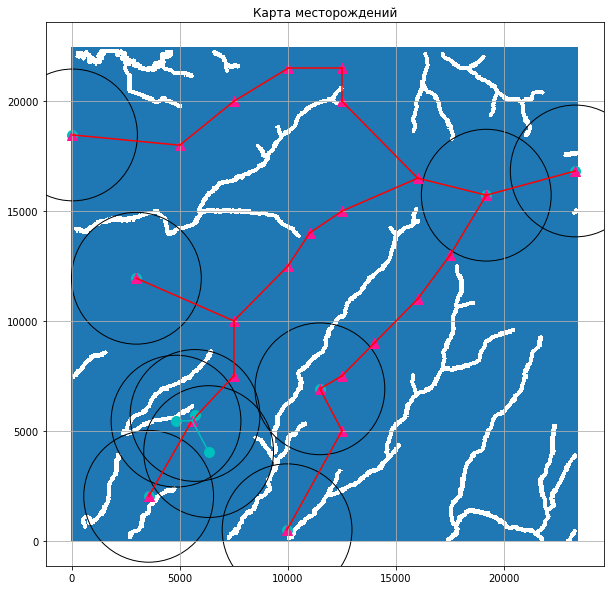

In [36]:
PADS_DOT = cluster_init(TARG_df,8)#random_init(TARG_df, 12)
PTL_DOT_df, PTL_TUBE_df, itogo = god_like(PADS_DOT,TARG_df, LIMI_df,max_cost, PADS_df, TUBE_df,iterations=5, plot=True, type_of_graph = 'min_ostov', optimum_control = optimum_control)
if itogo < best_itogo:
    best_PTL_DOT_df, best_PTL_TUBE_df, best_itogo = PTL_DOT_df, PTL_TUBE_df, itogo

In [417]:
best_itogo

5731878.662475963

# Запись

In [413]:
write_to_file(path, best_PTL_DOT_df, best_PTL_TUBE_df)

# Цикл по 

In [343]:
n = 6
for i in range(10):
    PADS_DOT =cluster_init(TARG_df, n)
    PTL_DOT_df, PTL_TUBE_df, itogo = god_like(PADS_DOT,TARG_df, LIMI_df,max_cost, PADS_df, TUBE_df,iterations=5, plot=False, type_of_graph = 'min_ostov', optimum_control=[[3950, 8050]])
    if itogo < best_itogo:
        best_PTL_DOT_df, best_PTL_TUBE_df, best_itogo =PTL_DOT_df, PTL_TUBE_df, itogo

itogo 0: 1485278.6774734943
itogo 1: 1462094.6032990124
itogo 2: 1461373.321615282
itogo 3: 1461312.5155347113
itogo 4: 1461307.7993920879
IIIIIIitogo: 1497928.8900442135
itogo 0: 1483551.8830108743
itogo 1: 1465057.1363127935
itogo 2: 1464923.1476274563
itogo 3: 1464920.2974162437
itogo 4: 1464919.9802765762
IIIIIIitogo: 1501541.070928757
itogo 0: 1485278.6774735
itogo 1: 1462094.6032990015
itogo 2: 1461373.3216153076
itogo 3: 1461312.5155347239
itogo 4: 1461307.7993921158
IIIIIIitogo: 1497928.8900442084
itogo 0: 1483551.8830108743
itogo 1: 1465057.1363127935
itogo 2: 1464923.1476274563
itogo 3: 1464920.2974162437
itogo 4: 1464919.9802765762
IIIIIIitogo: 1501541.070928757
itogo 0: 1483551.8830108743
itogo 1: 1465057.1363127935
itogo 2: 1464923.1476274563
itogo 3: 1464920.2974162437
itogo 4: 1464919.9802765762
IIIIIIitogo: 1501541.070928757
itogo 0: 1485278.6774734997
itogo 1: 1462094.6032989977
itogo 2: 1461373.321615282
itogo 3: 1461312.5155346608
itogo 4: 1461307.799391835
IIIIIIito